# Dog Vs Cat: A CNN based Dog/Cat Classifer 

## Enviroment Setup

In [46]:
import numpy as np
import pandas as pd
import os
import glob
import cv2
from collections import Counter
import random

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dropout, ELU
from keras.layers.convolutional import Cropping2D, Convolution2D, MaxPooling2D
from keras.layers.core import Lambda, Dense, Activation, Flatten
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19

import logging

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 5.0)

import seaborn as sns
sns.set(style="white", color_codes=True)





## Global Variables Initialazation

In [5]:
TRAIN_DATA_PATH_LIST = ["./train"]

IMAGE_INPUT_SHAPE = (224, 224, 3)

LABEL_LIST = sorted(["dog", "cat"])

DO_VISUALIZE = True
RUN_HOMEBREW_MODEL = False

logger = logging.getLogger("DogVsCat")  
logger.setLevel(logging.DEBUG) 
logging.basicConfig(level=logging.DEBUG,
                filename='DogCat.log',
                filemode='w')

# Load, Analysis, Visualize and Encode Data

* load raw datas
* transform image string labels to one-hot encoding
* visualize data

loading data from: ./train
total 12500 cat images loaded.
total 12500 dog images loaded.
total 25000 raw data samples loaded.


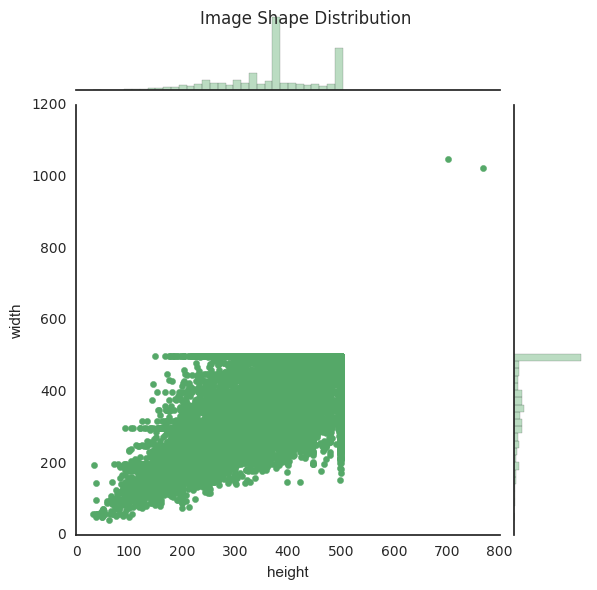

In [52]:
def label_one_hot_encoding(labe_list):
    encoder = LabelEncoder()
    transfomed_label = encoder.fit_transform(labe_list)
    one_hot_encoded_labels =  np_utils.to_categorical(transfomed_label)
    one_hot_label_dict = {}
    for i  in range(len(labe_list)):
        one_hot_label_dict[labe_list[i]] = one_hot_encoded_labels[i] 
    
    #inverse the label -> one-hot enchoding 1 to 1 map, turn list to tuple as the key
    inverse_one_hot_encoding_dict = {tuple(v): k for k, v in one_hot_label_dict.items()} 
    
    logger.info("one hot encoding for labels: ", one_hot_label_dict)
    logger.info(one_hot_label_dict)
    return one_hot_label_dict, inverse_one_hot_encoding_dict
    



def load_samples(DATA_PATH, one_hot_encoding_dict):
    """
    read all original data to a list, the element in the list is [one_hot_label, image_path]
    return value is the list
    """
    labels = one_hot_encoding_dict.keys()    
    samples = [] # format: [one_hot_label, image_path]
    temp_size = 0
    for dir in DATA_PATH: 
        print("loading data from: " + dir)
        for key in labels:           
            samples += [[one_hot_encoding_dict[key],file] for file in glob.glob(os.path.join(dir, key + '*.jpg'))]
            temp_size = len(samples) - temp_size    
            print("total " + str(temp_size) + " " + key + " images loaded.")
            logger.info("total " + str(temp_size) + " " + key + " images loaded.")
            temp_size = len(samples)
        
        print("total " + str(temp_size) + " raw data samples loaded.")
        logger.info("total " + str(temp_size) + " raw data samples loaded.")
        
    return samples    





    




def image_dimension_analysis(raw_sample_list, one_hot_encoding_dict, inverse_one_hot_encoding_dict):
    """
    image width，height and aspect ratio counter, return value is a dict    
    """   
    labels = one_hot_encoding_dict.keys()
   
    label_list,image_path_list, width_list, height_list, aspect_ratio_list = [], [], [], [], []
    for sample in raw_sample_list:
        label = inverse_one_hot_encoding_dict[tuple(sample[0])]       
        label_list.append(label)
        image_path_list.append(sample[1])
        
        image = cv2.imread(sample[1])
        
        height_list.append(image.shape[0])
        width_list.append(image.shape[1])
        aspect_ratio_list.append(np.float(image.shape[1]/image.shape[0]))


    df = pd.DataFrame({
        "label": label_list, 
        "image_path": image_path_list, 
        "height": height_list, 
        "width": width_list, 
        "aspect_ratio": aspect_ratio_list
    })
    
    image_shape_plot = sns.jointplot(x="height", y="width", data=df, stat_func=None, kind="scatter",color="g")
    sns.plt.suptitle('Image Shape Distribution')
    #fig = image_shape_plot.get_figure()
    image_shape_plot.savefig("./resource/image_shape_distribution.png")
    return df
    






    
one_hot_encoding_dict, inverse_one_hot_encoding_dict = label_one_hot_encoding(LABEL_LIST)

raw_samples = load_samples(TRAIN_DATA_PATH_LIST, one_hot_encoding_dict)

image_info_df =  image_dimension_analysis(raw_samples, one_hot_encoding_dict, inverse_one_hot_encoding_dict)







## Visualize Regular and Irregular Images

from the analysis above, we found most of image's width/height is within (200, 500), but there're also some images with large size. It's better to take a look at the irregular images.

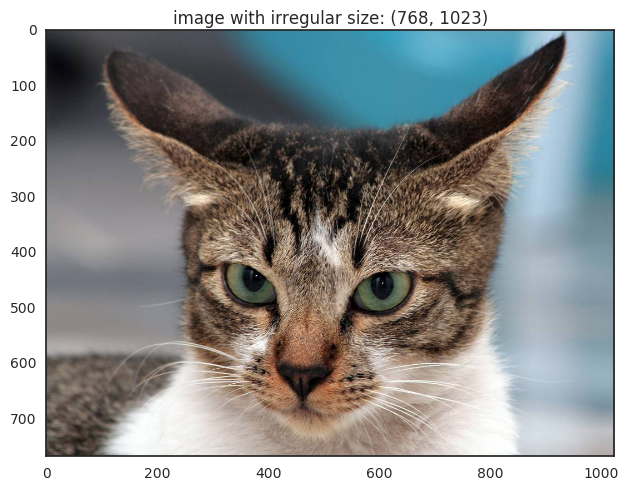

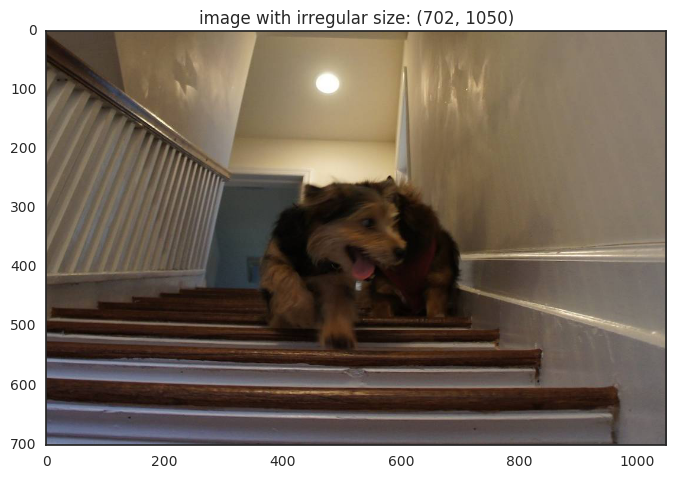

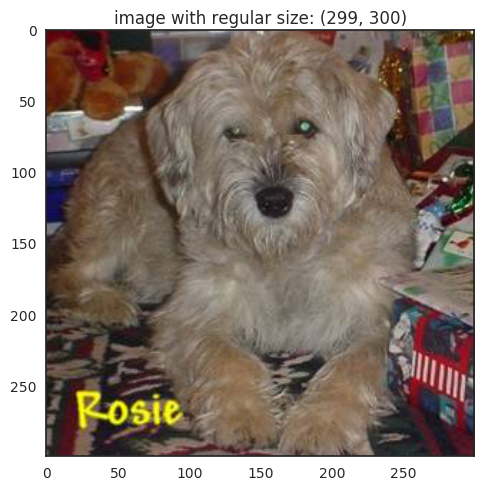

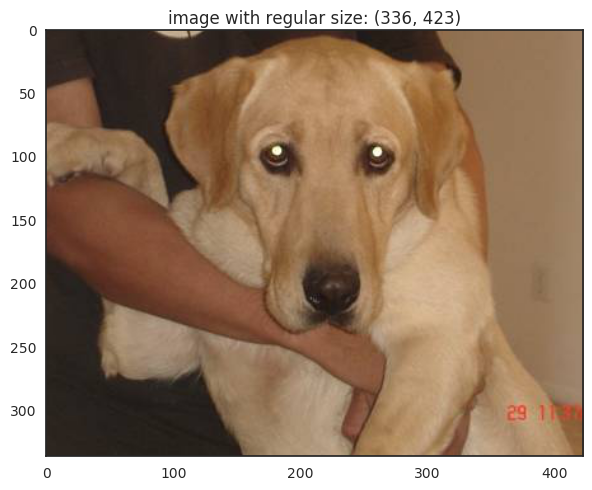

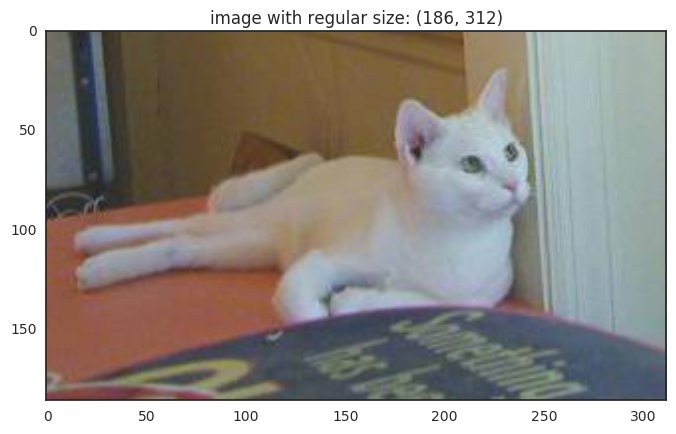

In [73]:
# visualize the irregular images
for i, row in image_info_df[image_info_df["width"] > 600].iterrows():
    #print(row)
    image = cv2.cvtColor(cv2.imread(row["image_path"]), cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title("image with irregular size: " +str(image.shape[:-1]))
    plt.show()
    
# visualize some regular image samples to compare
for i, row in image_info_df[image_info_df["width"] <  450].sample(3).iterrows():
    image = cv2.cvtColor(cv2.imread(row["image_path"]), cv2.COLOR_BGR2RGB)
    plt.title("image with regular size: " +str(image.shape[:-1]))
    plt.imshow(image)
    plt.show()
    

## Image Resize Helper Function

In [74]:
def resize_image(image, output_shape = (100, 100, 3)):
    """
    resize image to proper shape, the color channel will not be touched
    """      
    shape = (output_shape[0], output_shape[1])    
    resized_image = cv2.resize(image, shape)
    return resized_image


    

    

## Functions to Setup Model From Scratch

In [11]:
def base_model_setup(input_shape, num_classes):    
    """
    homebrew base model
    """     
    model = Sequential()    
    
    model.add(Lambda(lambda x: x/127.5 -1., input_shape = input_shape))
    model.add(Convolution2D(64,3,3)) #(32,3,3)
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Convolution2D(32,3,3))  #(32,3,3)  
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Convolution2D(32,3,3))  #(32,3,3)      
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))    
    
    model.add(Flatten())
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))    
    model.add(Dense(num_classes))
    #print(model.summary())
    return model 


        

def create_homebrew_models(input_shape = (224, 224, 3), num_classes = 2, output_activation_list = ['sigmoid'] , loss_function_list = ['categorical_crossentropy'], optimizer_list = ["rmsprop", "adam"]):
    """
    create homebrew models from homebrew base model with different final activation functions and loss functions
    """      
    model_dict = {}
    for loss_function in loss_function_list:
        for optimizer in optimizer_list:
            for output_activation in output_activation_list:
                model = base_model_setup(input_shape, num_classes)
                model.add(Activation(output_activation))
                
                model.compile(loss = loss_function,  optimizer = optimizer , metrics = ['accuracy'])
                name = "activation=" + output_activation + "_loss=" + loss_function + "_optimizer=" + optimizer
                print("homebrew model generation: " + name)
                print(model.summary())
                
                model_dict[name] = model
    
    return model_dict    
    
    
#home_brew_model_dict = create_homebrew_models(input_shape = (224, 224, 3), num_classes = 2, output_activation_list = ['sigmoid', 'softmax'] , loss_function_list = ['categorical_crossentropy' ], optimizer_list = ["rmsprop", "adam"])    
    

## Functions to Setup Model from Pre-trainned Model 

In [6]:
def fine_tune_pretrained_model(input_shape = (224, 224, 3) , num_classes = 2, pre_trained_model_list = ["ResNet"]):
    """
    create models based on pre-trainned model's front end
    """   
    
    model_dict = {}
    
    for model_type in pre_trained_model_list:
        if model_type == "ResNet":
            pre_trained_model = ResNet50(weights='imagenet', input_shape = input_shape, include_top = False)
        elif model_type == "VGG19":
            pre_trained_model = VGG19(weights='imagenet', input_shape = input_shape, include_top=False)
        elif model_type == "VGG16":
            pre_trained_model = VGG19(weights='imagenet', input_shape = input_shape, include_top=False)
    
        print("load pre-trainned model weight: " + model_type)
        
        for layer in pre_trained_model.layers:
            layer.trainable = False  # freeze the front-end weight of pre-trained model weight
        
        #pre_trained_model.summary()    
        
        # add back-end for current problem 
        x = pre_trained_model.output       
        x = Flatten(name='flatten')(x)        
        x = Dense(256, activation = "relu", name="fc256") (x)        
        x = Dense(64, activation = "relu", name="fc64") (x)
        x = Dropout(0.5) (x)    
        x = Dense(num_classes, name="fc_output") (x)
        predictions =  Activation('softmax') (x)
        
        model = Model(input = pre_trained_model.input,  output=predictions)
        model.compile(loss = 'categorical_crossentropy',  optimizer = "rmsprop" , metrics = ['accuracy'])
        print(model_type)
        print(model.summary())
        model_dict[model_type] = model
    
    return model_dict


#fine_tune_pretrained_model_dict =  fine_tune_pretrained_model(num_classes = 2, pre_trained_model_list = ["VGG16","VGG19","ResNet"])

## Image Sample Batch Generator for Model Training and Testing 

In [7]:
def sample_generator(samples, batch_size=10):
    
    while True:
        samples = shuffle(samples)
        num_samples = len(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset + batch_size]
            images = []
            one_hot_labels = []
            
            for sample in batch_samples:
                image = cv2.imread(sample[1])
                image = resize_image(image, output_shape = IMAGE_INPUT_SHAPE)

                images.append(image)
                one_hot_labels.append(sample[0])
                #plt.imshow(image)
                #plt.show()
            
            X_train = np.array(images)
            y_train = np.array(one_hot_labels)
            
            #print("y_train", y_train)
            yield shuffle(X_train, y_train)

    
'''# generator unit test
test_x, test_y = next(sample_generator(raw_samples, batch_size = 1))
test_x = np.squeeze(test_x)
print(test_x.shape)
plt.imshow(cv2.cvtColor(test_x, cv2.COLOR_BGR2RGB))
plt.title(str(test_y))
'''

'# generator unit test\ntest_x, test_y = next(sample_generator(raw_samples, batch_size = 1))\ntest_x = np.squeeze(test_x)\nprint(test_x.shape)\nplt.imshow(cv2.cvtColor(test_x, cv2.COLOR_BGR2RGB))\nplt.title(str(test_y))\n'

## Model Fit History Visualization

In [8]:
def model_fit_history_visualization(history, name):        
        #  accuracy history
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.savefig("./resource/" + name + '_accuracy.png')
        plt.show()
        # loss history
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.savefig("./resource/" + name + '_loss.png')
        plt.show()

## model training flow setup

label is encoded by one-hot encoding:  {'dog': array([ 0.,  1.]), 'cat': array([ 1.,  0.])}
loading data from: ./train
total 12500 dog images loaded.
total 12500 cat images loaded.
total 25000 raw data samples loaded.
raw sample loaded.
{(0.0, 1.0): 'dog', (1.0, 0.0): 'cat'}
most common dog image height:  [(374, 1400), (375, 1345), (500, 1040), (499, 993), (332, 153), (333, 152), (399, 150), (299, 130), (240, 123), (300, 122)]
most common dog image width:  [(500, 2486), (499, 2398), (350, 197), (400, 194), (399, 175), (375, 174), (299, 162), (319, 160), (320, 155), (300, 146)]
most common cat image height:  [(374, 1684), (375, 1614), (499, 846), (500, 804), (333, 166), (332, 155), (239, 149), (240, 130), (299, 108), (359, 89)]
most common cat image width:  [(499, 2914), (500, 2859), (349, 188), (300, 181), (350, 175), (319, 165), (320, 164), (299, 149), (399, 149), (400, 142)]


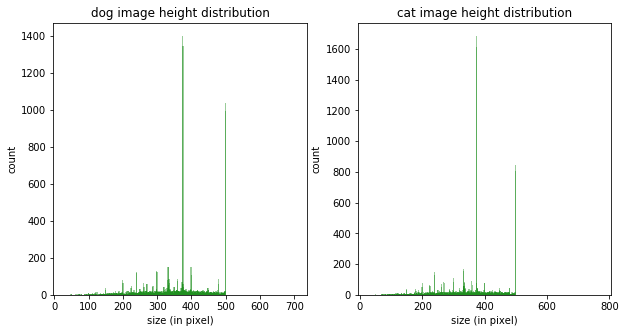

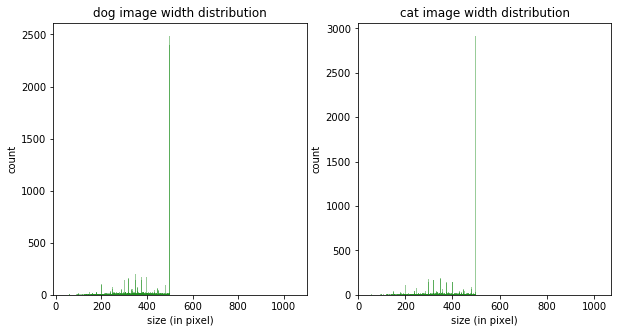


train sample count:  16000 
validation sample count:  4000 
test sample count:  5000
build home brew model...
homebrew model generation: activation=softmax_loss=categorical_crossentropy_optimizer=rmsprop
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_8 (Lambda)                (None, 224, 224, 3)   0           lambda_input_8[0][0]             
____________________________________________________________________________________________________
convolution2d_22 (Convolution2D) (None, 222, 222, 64)  1792        lambda_8[0][0]                   
____________________________________________________________________________________________________
activation_244 (Activation)      (None, 222, 222, 64)  0           convolution2d_22[0][0]           
________________________________________________________________________________________

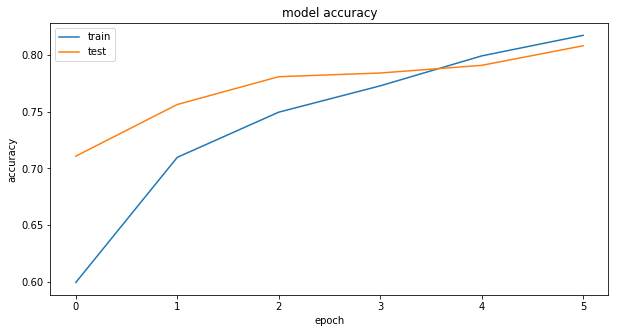

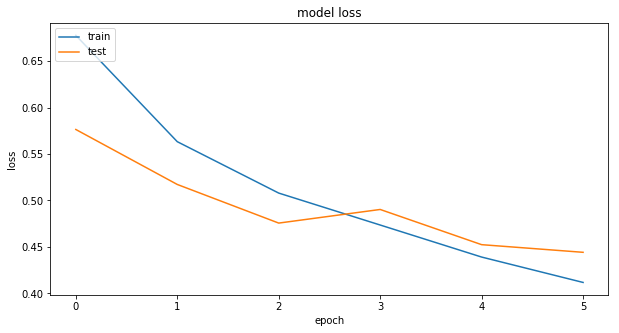

activation=softmax_loss=categorical_crossentropy_optimizer=rmsprop score: [0.42764954765637714, 0.80466664632161455]
model activation=softmax_loss=categorical_crossentropy_optimizer=rmspropsaved.
VGG16 fitting started...
Epoch 1/3
16000/16000 [==============================] - 362s - loss: 1.2879 - acc: 0.9158 - val_loss: 0.6273 - val_acc: 0.9595

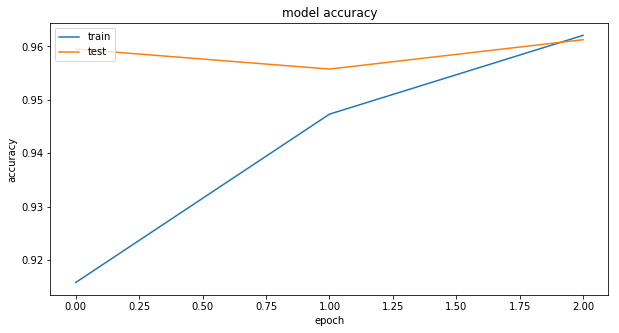

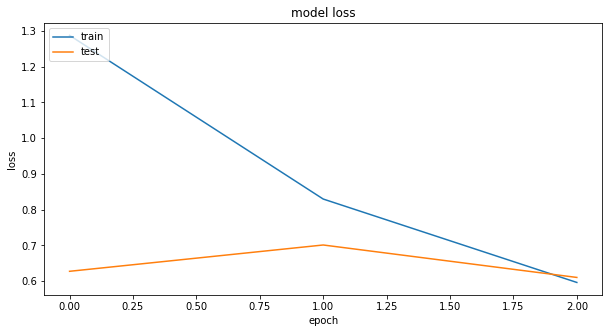

VGG16 score: [0.50961791078249619, 0.9660000205039978]
model VGG16saved.
VGG19 fitting started...
Epoch 1/3
16000/16000 [==============================] - 362s - loss: 2.0976 - acc: 0.8664 - val_loss: 1.9134 - val_acc: 0.8773

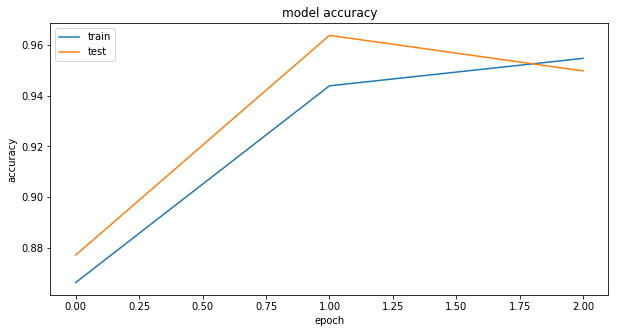

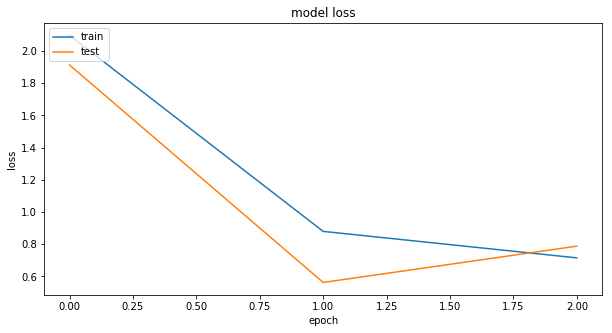

VGG19 score: [0.7676462769508362, 0.95066669782002766]
model VGG19saved.
ResNet fitting started...
Epoch 1/3
16000/16000 [==============================] - 202s - loss: 0.1899 - acc: 0.9321 - val_loss: 0.0519 - val_acc: 0.9820

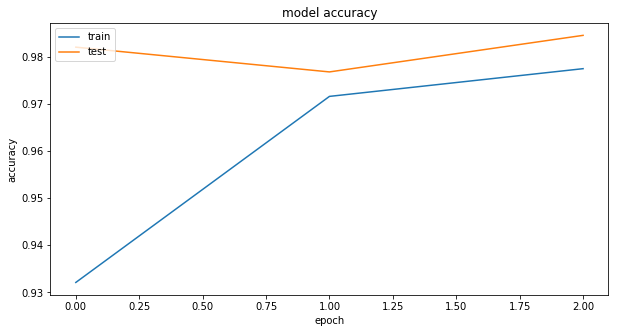

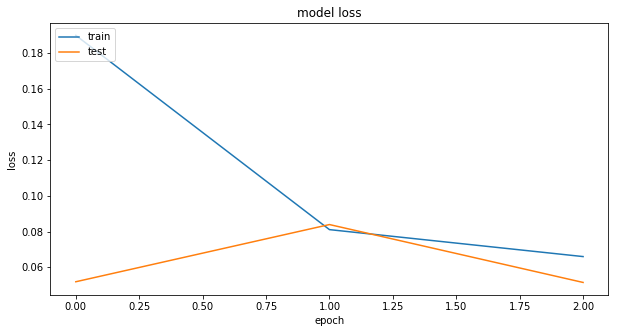

ResNet score: [0.04814157299697399, 0.98866666952768967]
model ResNetsaved.


In [17]:
def flow_setup():
    
    one_hot_encoding_dict = label_one_hot_encoding(LABEL_LIST)
    print("label is encoded by one-hot encoding: ", one_hot_encoding_dict)
    
    logger.info(one_hot_encoding_dict)
    
    raw_samples = load_samples(TRAIN_DATA_PATH_LIST, one_hot_encoding_dict)
    print("raw sample loaded.")
    
    image_shape_counter = raw_data_analysis(raw_samples, one_hot_encoding_dict)
    
    
    if DO_VISUALIZE:
        visualize_image_size_distribution(image_shape_counter)
    
    train_validation_samples, test_samples = train_test_split(raw_samples, test_size = 0.2, random_state = 42)
    train_samples, validation_samples = train_test_split(train_validation_samples, test_size = 0.2, random_state = 42)
    print()
    print("train sample count: ", len(train_samples), "\nvalidation sample count: ", len(validation_samples), "\ntest sample count: ", len(test_samples))
    
    
    train_generator = sample_generator(train_samples, batch_size = 100)
    validation_generator = sample_generator(validation_samples, batch_size = 100)
    test_generator = sample_generator(test_samples, batch_size = 100)


    
    print("build home brew model...")
    hombrew_model_dict =  create_homebrew_models(input_shape = IMAGE_INPUT_SHAPE, num_classes = 2, output_activation_list = ['softmax'] , loss_function_list = ['categorical_crossentropy' ], optimizer_list = ["rmsprop"])
    print("build model from pre-trained model...")
    pre_trained_model_dict = fine_tune_pretrained_model(num_classes = 2, pre_trained_model_list = ["VGG16","VGG19","ResNet"])

    model_dict = {"homebrew": hombrew_model_dict, "pre_trained": pre_trained_model_dict}
    
    print("model build finished.")    
    for model_type in sorted(model_dict.keys()):
        for name in model_dict[model_type]: 
            model = model_dict[model_type][name]
            print(name + " fitting started...")
            
            if model_type == "homebrew":
                num_epochs = 6
            else:
                num_epochs = 3
            
            history_object = model.fit_generator(train_generator, samples_per_epoch= int(len(train_samples)), validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=num_epochs, verbose=1)
        
            if DO_VISUALIZE:
                model_fit_history_visualization(history_object, name)
        
            score = model.evaluate_generator(test_generator, 1500, max_q_size=10, nb_worker=1, pickle_safe=False)
            print(name + " score:", score)
            model.save("./models/" + name + ".h5" )
            print("model " + name + "saved.")
    

flow_setup()    